In [36]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch_scatter import scatter_max, scatter_mean
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import re
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

In [37]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

In [4]:
import string
allowed_chars = string.ascii_letters + string.digits + string.punctuation
all_chars = set(allowed_chars)

In [5]:
with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
token_vocab_dict = dict(zip(all_vocab_str, embeddings))

In [6]:
with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

128001

In [9]:
import string
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' \t'
all_chars = set(allowed_chars)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
folder_path = r'C:\Users\fardin\Projects\CGNet\Data\TextClassification\IMDB'
# t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [11]:
keep_ratio = 0.1
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
test_df['Content'] = test_df['text']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.DataFrame(np.concatenate([train_df.values, test_df.values]), columns=train_df.columns)
df.shape

(5000, 2)

In [12]:
class_id = {c:i for i, c in enumerate(sst_classes)}
id_class = {i:c for i, c in enumerate(sst_classes)}

In [13]:
# %%time
vocabs_lists = list(token_vocab_dict.keys())
term_frequencies = {t:1 for t in vocabs_lists}
temp_term_frequencies = {}

char_set = set()
for doc in train_df.Content.values:
    tokens_list = tokenizer.tokenize(doc)
    char_set.update(set(' '.join(tokens_list)))
    char_set.update(set(doc))
    new_tokens = {t.strip('▁').lower() for t in tokens_list}
    for t in new_tokens:
        if t not in temp_term_frequencies:
            temp_term_frequencies[t] = 0
        temp_term_frequencies[t] += 1
        
for k, v in term_frequencies.items():
    stripped_token = k.strip('▁').lower()
    term_frequencies[k] = temp_term_frequencies[stripped_token] if stripped_token in temp_term_frequencies else 1

# del temp_term_frequencies
    
for doc in test_df.Content.values:
    char_set.update(set(' '.join(tokenizer.tokenize(doc))))
    char_set.update(set(doc))
len(char_set)

allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = sorted(list(set(''.join(char_set).join(allowed_chars))))
vocab_dict = {c:i for i, c in enumerate(all_chars)}  # [Problems]
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [14]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x

In [15]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, token_dict, sentiment_dict, tokenizer, token_frequencies, sampling_equation, shuffle=True, batch_size=128) -> None:
        super().__init__()
        if len(y) % batch_size != 0:
            self.shortage = ((len(y) // batch_size)+1)*batch_size - len(y)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            y = np.concatenate([y, empty_labels])
            X = np.concatenate([X, empty_strings])
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.token_frequencies = token_frequencies
        self.max_token_count = 0
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            g_data = self.content_to_graph(doc, sampling_equation)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        return self.all_data[index], self.y[index]
        
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        return np.array(groups), groups_size
        
    def content_to_graph(self, doc, sampling_equation):
        tokens = self.tokenizer(doc)
        if len(tokens) == 0:
            tokens = ['empty']
                        
        token_lengths = [len(t) for t in tokens]
        tokens.append('\x01')
        
        token_lengths.append(len(tokens[-1])-1)
        token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
        token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
        token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
        token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
        token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
        doc = ' '.join(tokens)
        characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
        token_positions = torch.arange(len(token_lengths), dtype=torch.long)
        token_indices = torch.repeat_interleave(token_positions, token_lengths)
        token_subsampling_probabilities = sampling_equation(torch.from_numpy(np.array([self.token_frequencies[t] if t in self.token_frequencies else 1 for t in tokens])))
        num_tokens = len(token_lengths)
        if num_tokens > self.max_token_count:
            self.max_token_count = num_tokens
        g_data = Data(x=characters,
                        token_positions=token_positions,
                        character_length = len(characters),
                        num_tokens = num_tokens,
                        token_indices=token_indices,
                        token_lengths=token_lengths,
                        token_embeddings=token_embs,
                        token_sentiments=token_sentiments,
                        token_subsampling_probabilities=token_subsampling_probabilities)
        return g_data
 
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices       

In [16]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [17]:
%%time
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

  1%|          | 14/2560 [00:00<00:41, 61.75it/s]

100%|██████████| 2560/2560 [00:42<00:00, 60.25it/s] 


CPU times: total: 5min 8s
Wall time: 1min 24s


In [18]:
X, y = next(iter(test_dataloader))

In [19]:
from torch_geometric.nn import GATv2Conv, SimpleConv

# Normalization on each feature of all tokens, for this we used batch norm class but with tokens at batch dimention
class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights, edge_data

In [20]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_counts*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_indices = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_counts )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_counts, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_indices[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_indices[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
        
    def re_gen_graph(self, x, edge_indices, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_indices[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_indices, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_counts*self.virtual_nodes
        # if v_n_e_counts>0:
        #     important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        # else:
        #     print(f'edge_weights.shape: {edge_weights.shape}')
        #     print(f'total_token_coutns: {total_token_coutns}')
        #     print(f'p_keep: {p_keep}')
        #     important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()
        # print(f'edge_weights.shape: {edge_weights.shape}')
        # print(f'edge_indices.shape: {edge_indices.shape}')
        # print(f'1: edge_weights: {edge_weights.shape}')
        important_indices = torch.topk(edge_weights.squeeze(), p_keep*total_token_counts, dim=0).indices
        # print(f'2: important_indices: {important_indices.shape}')
        # print(f'2.5: \n {edge_weights} \n\n {important_indices}')

        # important_indices = torch.arange(total_token_counts, dtype=torch.int64, device=x.device)
        # important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        # print(f'3: random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape},')
        base_numel = random_links.numel() + lattice_links.numel()*2
        # print(f'4: base_numel: {base_numel}')
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        # print(f'5: new_edge_index: {new_edge_index.shape}')
        # print(f'new_edge_index.shape 1: {new_edge_index.shape}, base_numel + important_indices.shape[0] + 2*v_n_e_counts: {base_numel + important_indices.shape[0] + 2*v_n_e_counts}')
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        # print(f'6: new_edge_index: {new_edge_index.shape}, random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape}')
        # print(f'new_edge_index.shape 2: {new_edge_index.shape}, edge_indices: {edge_indices.shape}, important_indices shape: {important_indices.shape}, important_indices max: {important_indices.max()}')
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_indices[:, important_indices]
        # print(f'7: new_edge_index: {new_edge_index.shape}')

        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_indices[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        # print(f'7.5: \n {new_edge_index} \n\n {token_subsampling_probabilities}')
        new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
    # def replace_unimportant_edges(self, edge_weights, x, edge_index, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
    #     v_n_e_counts = total_token_coutns*self.virtual_nodes
    #     if v_n_e_counts>0:
    #         important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
    #     else:
    #         print(f'edge_weights.shape: {edge_weights.shape}')
    #         print(f'total_token_coutns: {total_token_coutns}')
    #         print(f'p_keep: {p_keep}')
    #         important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
    #     # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

    #     important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
    #     important_indices = important_indices.view(-1)
    #     random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
    #     base_numel = random_links.numel() + lattice_links.numel()*2
        
    #     new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
    #     self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
    #     new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
    #     if(self.virtual_nodes>0):
    #         new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
    #     # for i in range(base.shape[1]):
    #     #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
    #     new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
    #     return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
    
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance):

        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_indices, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_indices[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_indices[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)
            
    def subsample_edges(self, edge_indices, token_subsampling_probabilities, keep_ratio=0.65):
        
        p = torch.rand(edge_indices.shape, dtype=torch.float, device=edge_indices.device)
        to_keep = (p<token_subsampling_probabilities[edge_indices]).float()
        to_keep = torch.topk(to_keep[0] + to_keep[1], (int)(edge_indices.shape[1]*keep_ratio), dim=0).indices
        edge_indices = edge_indices[:, to_keep]
        return edge_indices

In [21]:
class Sentiment_Injection(nn.Module):
    
    def __init__(self, hidden_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.conv1 = nn.Conv1d(2, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, token_sentiments):
        x1 = F.relu_(self.bn1(self.conv1(token_sentiments.T).T))
        x = F.relu_(self.conv2(torch.cat([x, x1], dim=1).T))
        return x

In [22]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary
import math

class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, isXaiTests=False, step_of_test = 0, num_tests=50, *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.num_out_features = num_out_features
        self.isXaiTests = int(isXaiTests)
        self.num_tests = num_tests
        self.step_of_test = step_of_test

        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        # self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
        # self.positional_encoding.weight = self.create_positional_encoding()
        
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        # if self.use_token_polarity[0]:
        # self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        # else:
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        # if self.use_token_polarity[1]:
        self.sentiment1  = Sentiment_Injection(hidden_dim)
        # if self.use_token_polarity[2]:
        self.sentiment2  = Sentiment_Injection(hidden_dim)
            
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, self.num_out_features)
        self.max_length = 0
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings, token_positions):
        # cumulative_token_indices = token_indices if not self.isXaiTests else self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        
        # print(f'2: {x.shape}')
        x = self.embedding(x)
        # print(f'2.5: {x.shape}')
        x = self.dropout(x)
        # print(f'2.6: {x.shape}')
        x = x.T
        # print(f'2.7: {x.shape}')
        # x = self.refine_shape(1, x, 0)
        x = F.relu(self.conv1(x))
        # print(f'2.8: {x.shape}')
        x = self.refine_shape(1, x, self.hidden_dim, 0)
        # print(f'2.8 refined: {x.shape}')
        x = F.relu(self.conv2(x))
        x = self.refine_shape(2, x, self.hidden_dim, 0)
        # print(f'2.9: {x.shape}')
        x = self.dropout(x)
        # x = self.refine_shape(4, x, 0)
        # print(f'3: {x.shape}')
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)

        # if self.use_token_polarity[0]:
        # x = torch.cat([x1, x2, token_sentiments.T], dim=0)
        # else:
        x = torch.cat([x1, x2], dim=0)
            
        # print(f'4: {x.shape}')
        x = F.relu(self.conv3(x))
        # x = x + self.positional_encoding(token_positions).T
        
        # print(f'4: {x.shape}')
        
        # print(f'4.5: {x.shape}, self.hidden_dim: {self.hidden_dim}, self.is_tests_token_level: {self.step_of_test}')
        # if self.isXaiTests and x.shape[0] != self.hidden_dim:
        # x = torch.chunk(x, self.num_tests ** (1 - self.isXaiTests), dim=0)
        x = self.refine_shape(3, x, self.hidden_dim, 0)
        
        # x = torch.chunk(x, (x.shape[0] // self.hidden_dim)**self.is_tests_token_level, dim=0)
        # x = torch.cat(x, dim=1)
        
        # if self.isXaiTests and x.shape[0] != self.hidden_dim:
        #     x = torch.chunk(x, self.num_tests, dim=0)
        #     x = torch.cat(x, dim=1)
        # x = x.reshape(self.hidden_dim, -1)
        # print("abababdadasd")
        # print(f'5: {x.shape}, {edge_index.shape}, {cumulative_token_indices.shape}, {token_sentiments.shape}, {token_lengths.shape}, {num_tokens.shape}, {character_length.shape}, {token_embeddings.shape}')
        # if self.use_token_polarity[1]:
        x = self.sentiment1(x.T, token_sentiments)

        # print(f'6: {x.shape}')
        x = self.refine_shape(4, x.T, self.hidden_dim, 1)
        # print(f'6 refined: {x.shape}')
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, token_subsampling_probabilities, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        # print(f'7: {graph.x.shape}')
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x, edge_weights, edge_index = self.gcnn1(graph.x, graph.edge_index, return_attention_weights = True)
        # print(f'7.1: {x.shape}')
        x = self.refine_shape(5, x, self.hidden_dim, 1)
        # print(f'7.1 2 : {len(torch.cat(edge_weights[1::2], dim=0))}')
        edge_weights = self.refine_edge_weights(edge_weights)
        edge_index = self.refine_edge_index(edge_index)
        
        # edge_weights = edge_weights[1].unsqueeze(-1)
        # print(f'7.5 edge_weights: {edge_weights.shape}, - {graph.edge_index.shape[1]}, {edge_weights.shape[0]}')
        # edge_weights = edge_weights[:min(graph.edge_index.shape[1], edge_weights.shape[0]), 0]
        # edge_weights = edge_weights.squeeze()
        
        edge_weights = edge_weights.unsqueeze(-1)
        # print(f'7.5 edge_weights: {edge_weights.shape}, - {edge_weights.shape[0]}')
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        # print(f'7.6 edge_weights: {edge_weights.shape}')
        # print(f'7.7: {x.shape}')
        x = self.refine_shape(5, x, self.hidden_dim, 1)
        # print(f'7.8 refined: {x.shape}')
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, token_subsampling_probabilities, len(token_lengths), num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        # print(f'8: {graph.x.shape}')
        
        # if self.use_token_polarity[2]:
        x = self.sentiment2(x, token_sentiments)
          
        # print(f'8.1: {x.shape}')
        x = self.refine_shape(6, x.T, self.hidden_dim, 1)
        # print(f'8.2 refined: {x.shape}')
        
        # print(f'9: {x.shape}')  
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        # x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        
        # print(f'10: {x.shape}')  
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        # print(f'11: {x.shape}')  
        sum1 = torch.sum(edge_weights) + torch.sum(edge_index)
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        edge_weights = self.refine_edge_weights(edge_weights)
        sum1 = sum1 + torch.sum(edge_weights) + torch.sum(edge_index) 
        
        # print(f'12: {x.shape}')  
        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        # print(f'13: {x.shape}')  
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        # print(f'14: {x.shape}')  
        return x + sum1 * 0.0
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices
    
    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)
    
    def refine_shape(self, test_step, x, num_chunks, section=0):
        x = torch.chunk(x, (x.shape[section] // num_chunks)**(self.step_of_test==test_step), dim=0)
        x = torch.cat(x, dim=1-section)
        return x
        
    def refine_edge_weights(self, edge_weights):
        edge_weights = edge_weights[1::2] + edge_weights[0::2] * 0
        edge_weights = [edge_weights[i] for i in range(len(edge_weights))]
        edge_weights = torch.cat(edge_weights, dim=0)
        return edge_weights
        
    def refine_edge_index(self, edge_index):
        edge_index = torch.cat([edge_index[::2].reshape(1, -1), edge_index[1::2].reshape(1, -1)], dim=0)
        return edge_index

In [23]:
# for p1 in [False, True]:
#     for p2 in [False, True]:
#         for p3 in [False, True]:
# print(f'\n{p1}, {p2}, {p3}: \n')
classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3080, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, isXaiTests=True, num_tests=len(X.num_tokens)).eval()
flopt_counter = FlopCounterMode(classifier_torch_model)
with flopt_counter:
    classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings, X.token_positions)

Module                                              FLOP    % Total
-----------------------------------------------  -------  ---------
 CNN_for_Text_No_Positional_Encoding.conv1       16.467B     29.05%
  - aten.convolution                             16.467B     29.05%
CNN_for_Text_No_Positional_Encoding              56.695B    100.00%
 - aten.convolution                              48.705B     85.91%
 - aten.addmm                                     7.990B     14.09%
 CNN_for_Text_No_Positional_Encoding.conv2       16.467B     29.05%
  - aten.convolution                             16.467B     29.05%
 CNN_for_Text_No_Positional_Encoding.conv3        3.684B      6.50%
  - aten.convolution                              3.684B      6.50%
 CNN_for_Text_No_Positional_Encoding.sentiment1   3.741B      6.60%
  - aten.convolution                              3.741B      6.60%
 CNN_for_Text_No_Positional_Encoding.gcnn1        1.535B      2.71%
  - aten.addmm                                  

In [24]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [25]:
from utilities.managers.ModelManager import ModelManager
from utilities.managers.ClassifierModelManager import ClassifierModelManager
from utilities.lightning_models.CnnGnnClassifierLightningModel import CnnGnnClassifierLightningModel

In [26]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [27]:
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_positional_encoder=[False, False, False]):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_positional_encoder[0]}_{use_positional_encoder[1]}_{use_positional_encoder[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.lightning_model.model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(model_manager.lightning_model, test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [28]:
torch.cuda.empty_cache()
import gc
gc.collect()

20

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([2560, 2])
torch.Size([2560, 2])
torch.Size([2560])
torch.Size([2560])


100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8588    0.8127    0.8351      1287
           1     0.8204    0.8649    0.8421      1273

    accuracy                         0.8387      2560
   macro avg     0.8396    0.8388    0.8386      2560
weighted avg     0.8397    0.8387    0.8386      2560

confusion matrix:
 tensor([[1046,  241],
        [ 172, 1101]])
torch.Size([2560, 2])
torch.Size([2560, 2])
torch.Size([2560])
torch.Size([2560])


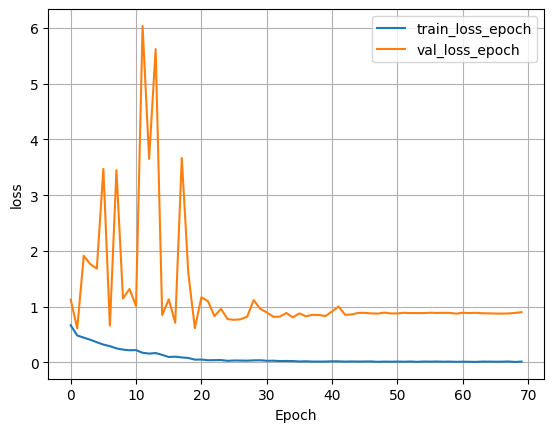

In [29]:
model_manager = train_model(70, 0.2, 0.000012, 0.0032, use_positional_encoder=[False, False, False])

In [30]:
from pathlib import Path
p = Path(r'logs/CNN-GNN_False_False_False\version_0\checkpoints\epoch=0-step=4.ckpt.pth')
not p.parent.mkdir(parents=True, exist_ok=True)

True

In [31]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def calculatge_metrics(chpt_path, target_data_loader, num_embedding):
        classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        classifier_torch_model.load_state_dict(torch.load(chpt_path, weights_only=True, map_location="cuda:0"))
        classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                batch_size=batch_size,
                                                user_lr_scheduler=True
                                                ).to(device).eval()
        
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in target_data_loader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds, labels=list(id_class.keys()))
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / (np.sum(cm, axis=0)+0.000001))
            recall = np.mean(np.diag(cm) / (np.sum(cm, axis=1)+0.000001))
            f1_score = (2*precision*recall)/(precision + recall+0.000001)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model

In [32]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [33]:
def calculate_average_metrics_mean(num_embedding, base_path = 'logs\CNN-GNN18_mr2k_seeds', start=0, interval=1):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []
    
    for i in range(start, start + interval):
        version_path = join(base_path, f'version_{i}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        print(onlyfiles[best_chpt_id])
        mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, num_embedding)
            
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)
        total_loss.append(loss)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')
    return classfier_lightning_model

In [35]:
classfier_lightning_model = calculate_average_metrics_mean(len(vocab_dict), r'logs\CNN-GNN_False_False_False', start=7)

epoch=39-step=400.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.8413281250000001
total_f1: 0.8417059309388965
total_prec: 0.8419670224686655
total_rec: 0.8414460020610957
total_loss: 0.8299449682235718


In [ ]:
classfier_lightning_model = calculate_average_metrics_mean(len(vocab_dict), r'logs\CNN-GNN_False_False_False', start=1)

epoch=18-step=190.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.811875
total_f1: 0.8151318115687147
total_prec: 0.8180321615364052
total_rec: 0.8122530513667903
total_loss: 0.5731271505355835


In [ ]:
classfier_lightning_model = calculate_average_metrics_mean(len(vocab_dict), r'logs\CNN-GNN_False_False_False', start=5)

epoch=46-step=470.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.8373437500000002
total_f1: 0.837505119123956
total_prec: 0.8375937584124117
total_rec: 0.8374175002353044
total_loss: 0.7775648832321167


In [ ]:
classfier_lightning_model1 = calculate_average_metrics_mean(len(vocab_dict), r'logs\CNN-GNN_False_False_False', start=1)
classfier_lightning_model3 = calculate_average_metrics_mean(len(vocab_dict), r'logs\CNN-GNN_False_False_False', start=3)

epoch=18-step=190.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.8114062500000001
total_f1: 0.8145425615031335
total_prec: 0.817327601474538
total_rec: 0.8117774512057855
total_loss: 0.5731271505355835


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'logs\\CNN-GNN_False_False_False\\version_3\\checkpoints'

In [ ]:
classfier_lightning_model1.model.embedding.weight

Parameter containing:
tensor([[-2.1667, -1.0284, -0.3112,  ...,  0.8440,  0.4139, -1.3559],
        [ 0.4477,  0.4483, -1.6092,  ...,  0.6777,  0.5552, -0.0789],
        [-0.1111, -1.1905, -1.0991,  ...,  0.0750,  0.3222,  0.2924],
        ...,
        [-0.2027, -0.7937,  0.0352,  ..., -0.7527,  0.2331,  0.1826],
        [ 0.3098,  0.4349, -0.3574,  ...,  0.1672,  0.1886, -0.9232],
        [-1.0632, -0.6390,  1.7161,  ...,  1.0442,  0.9414, -0.1757]],
       device='cuda:0', requires_grad=True)

In [ ]:
classfier_lightning_model3.model.embedding.weight

Parameter containing:
tensor([[-2.1667e+00, -1.0284e+00, -3.1116e-01,  ...,  8.4399e-01,
          4.1394e-01, -1.3559e+00],
        [ 5.2677e-01,  6.3853e-01, -1.5004e+00,  ...,  4.7975e-01,
          5.7680e-01, -1.4392e-01],
        [-1.2900e-01, -1.2595e+00, -1.1261e+00,  ...,  2.0922e-03,
          3.4685e-01,  1.9804e-01],
        ...,
        [-2.5178e-01, -7.1559e-01, -1.1819e-01,  ..., -5.6713e-01,
          4.9578e-01,  1.1270e-01],
        [ 2.5813e-01,  3.8796e-01, -3.1091e-01,  ...,  1.9647e-01,
          2.2127e-01, -9.7274e-01],
        [-1.0966e+00, -6.0523e-01,  1.5983e+00,  ...,  1.0477e+00,
          9.0805e-01, -8.9105e-02]], device='cuda:0', requires_grad=True)

In [ ]:
test_dataset[0][0].x

tensor([145,  77,  37,  ...,   1,  37, 148])